In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import toml
import sleap_io as sio
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from scipy import spatial
from qd_analysis.fig import setup_plotting_env
setup_plotting_env()

In [3]:
save_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/panels/2025-04 (QD paper round 2)"


In [4]:
config = toml.load("../preprocessing/config.toml")
config["dirs"]["analysis"]

'/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/_analysis'

## Gather data and predicted keypoints

1. At this point assumes we've run ../preprocessing/05_gathering...

In [5]:
root_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/"
training_fname = os.path.join(root_dir, "keypoints_basler_nir_plexiglass_arena/sleap_training_round2/_labels/basler-nir-plexiglass-arena-keypoints-fused-round2_weights-None_bpass-None.slp")


In [6]:
training_labels = sio.load_slp(training_fname)
use_skeleton = training_labels.skeleton

In [7]:
node_names = [_node.name for _node in use_skeleton.nodes]

In [8]:
new_labeled_frames = []
kpoint_dcts = []
for i, _label in tqdm(
    enumerate(training_labels.labeled_frames), total=len(training_labels.labeled_frames)
):
    points_pred = _label.instances[0].numpy()
    dist_matrix = spatial.distance.squareform(spatial.distance.pdist(points_pred))
    np.fill_diagonal(dist_matrix, np.nan) 
    min_dists = np.nanmin(dist_matrix, axis=1)
    kpoint_dct = {}
    for _node, _dist in zip(node_names, min_dists):
        kpoint_dct[_node] = _dist
    kpoint_dcts.append(kpoint_dct)

  0%|          | 0/862 [00:00<?, ?it/s]

/tmp/ipykernel_1447544/2915916953.py:9: RuntimeWarning: All-NaN slice encountered
  min_dists = np.nanmin(dist_matrix, axis=1)


In [9]:
# now combine back, tail, paws
segments = {}
segments["back"] = ["back_bottom","back_middle","back_top"]
segments["paws"] = ["foreleg_L", "foreleg_R", "hindleg_L", "hindleg_R"]
segments["tail"] = ["tail_base", "tail_middle", "tail_tip"]
segments["knee"] = ["knee_L", "knee_R"]
map_body_part_to_segment = {}
for k, v in segments.items():
    for _v in v:
        map_body_part_to_segment[_v] = k

In [10]:
aliases = {
    "back_bottom": "Back bottom",
    "back_middle": "Back middle",
    "back_top": "Back top",
    "knee_L": "L. knee",
    "knee_R": "R. knee",
    "hindleg_L": "L. hindpaw",
    "hindleg_R": "R. hindpaw",
    "foreleg_L": "L. forepaw",
    "foreleg_R": "R. forepaw",
    "tail_base": "Tail base",
    "tail_middle": "Tail middle",
    "tail_tip": "Tail tip",
}

In [11]:
crowding_df = pd.DataFrame(kpoint_dcts)

In [12]:
crowding_df = crowding_df.melt(var_name="kpoint_name")
crowding_df["segment"] = crowding_df["kpoint_name"].map(map_body_part_to_segment)
crowding_df["kpoint_alias"] = crowding_df["kpoint_name"].map(aliases)

In [13]:
hist_kwargs = {"bins": np.arange(0,101,2),
               "element": "step",
               "alpha": 1.,
               "clip_on": False,
               "fill": True,
               "linewidth": 0}

In [14]:
nkpoints = crowding_df["kpoint_alias"].nunique()
nsegments = crowding_df["segment"].nunique()

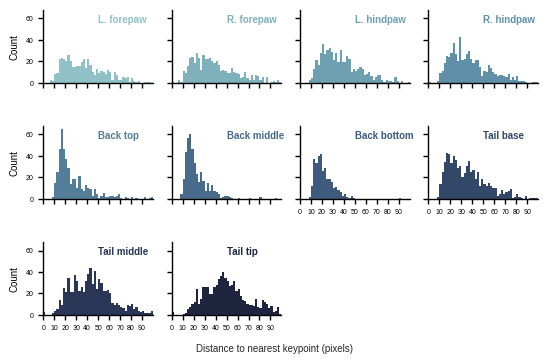

In [15]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(nkpoints, rot=-0.25, light=0.7)
g = sns.FacetGrid(
    crowding_df, col="kpoint_alias", hue="kpoint_alias", aspect=1.1, height=1.25, palette=pal, sharey=True, sharex=True, col_wrap=4,
)
g.map(
    sns.histplot,
    "value",
    **hist_kwargs,
)
# g.map(sns.kdeplot, "l2_error", clip_on=False, color="w", lw=2, bw_adjust=0.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0.5,
        0.8,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )

g.map(label, "segment")
# g.figure.subplots_adjust(hspace=0.25)
g.set_titles("")
g.set(xlim=(0,100), xticks=np.arange(0,100,10), xlabel="")
g.fig.supxlabel("Distance to nearest keypoint (pixels)", fontsize=7)
g.fig.savefig(os.path.join(save_dir, "manual_data_keypoint_nn_dist.pdf"), bbox_inches="tight", dpi=600)

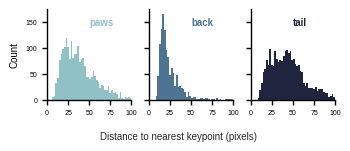

In [25]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(nsegments, rot=-0.25, light=0.7)
g = sns.FacetGrid(
    crowding_df, col="segment", hue="segment", aspect=.7, height=1.6, palette=pal, sharey=True, sharex=True, col_wrap=4,
)
g.map(
    sns.histplot,
    "value",
    **hist_kwargs,
)
# g.map(sns.kdeplot, "l2_error", clip_on=False, color="w", lw=2, bw_adjust=0.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0.5,
        0.8,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )

g.map(label, "segment")
# g.figure.subplots_adjust(hspace=0.25)
g.set_titles("")
g.set(xlim=(0,100), xticks=np.arange(0,101,25), xlabel="")
g.fig.supxlabel("Distance to nearest keypoint (pixels)", fontsize=7, x=.4, ha="center")
g.fig.savefig(os.path.join(save_dir, "manual_data_keypoint_nn_dist_segments.pdf"), bbox_inches="tight", dpi=600)

In [27]:
crowding_df.groupby("segment")["value"].quantile(.05)

segment
back    12.153051
paws    14.650156
tail    15.994127
Name: value, dtype: float64